(dataset-spec)=
# Quantify dataset specification

```{seealso}
The complete source code of this tutorial can be found in

{nb-download}`Quantify dataset - specification.ipynb`
```

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import xarray as xr
from rich import pretty

import quantify_core.data.dataset_adapters as dadapters
import quantify_core.data.dataset_attrs as dattrs
from quantify_core.data import handling as dh
from quantify_core.utilities import dataset_examples
from quantify_core.utilities.examples_support import round_trip_dataset
from quantify_core.utilities.inspect_utils import display_source_code

pretty.install()

dh.set_datadir(Path.home() / "quantify-data")  # change me!

This document describes the Quantify dataset specification.
Here we focus on the concepts and terminology specific to the Quantify dataset.
It is based on the Xarray dataset, hence, we assume basic familiarity with the {class}`xarray.Dataset`.
If you are not familiar with it, we highly recommend to first have a look at our {ref}`xarray-intro` for a brief overview.

(sec-coordinates-and-variables)=

## Coordinates and Variables

The Quantify dataset is an xarray dataset that follows certain conventions. We define "subtypes" of xarray coordinates and variables:

(sec-main-coordinates)=

### Main coordinate(s)

- Xarray **Coordinates** that have an attribute {attr}`~quantify_core.data.dataset_attrs.QCoordAttrs.is_main_coord` set to `True`.

- Often correspond to physical coordinates, e.g., a signal frequency or amplitude.

- Often correspond to quantities set through {class}`.Settable`s.

- The dataset must have at least one main coordinate.

  > - Example: In some cases, the idea of a coordinate does not apply, however a main coordinate in the dataset is required. A simple "index" coordinate should be used, e.g., an array of integers.

- See also the method {func}`~quantify_core.data.dataset_attrs.get_main_coords`.

(sec-secondary-coordinates)=

### Secondary coordinate(s)

- A ubiquitous example is the coordinates that are used by "calibration" points.
- Similar to {ref}`main coordinates <sec-main-coordinates>`, but intended to serve as the coordinates of {ref}`secondary variables <sec-secondary-variables>`.
- Xarray **Coordinates** that have an attribute {attr}`~quantify_core.data.dataset_attrs.QCoordAttrs.is_main_coord` set to `False`.
- See also {func}`~quantify_core.data.dataset_attrs.get_secondary_coords`.

(sec-main-variables)=

### Main variable(s)

- Xarray **Variables** that have an attribute {attr}`~quantify_core.data.dataset_attrs.QVarAttrs.is_main_var` set to `True`.
- Often correspond to a physical quantity being measured, e.g., the signal magnitude at a specific frequency measured on a metal contact of a quantum chip.
- Often correspond to quantities returned by {class}`.Gettable`s.
- See also {func}`~quantify_core.data.dataset_attrs.get_main_vars`.

(sec-secondary-variables)=

### Secondary variables(s)

- Again, the ubiquitous example is "calibration" datapoints.
- Similar to {ref}`main variables <sec-main-variables>`, but intended to serve as reference data for other main variables (e.g., calibration data).
- Xarray **Variables** that have an attribute {attr}`~quantify_core.data.dataset_attrs.QVarAttrs.is_main_var` set to `False`.
- The "assignment" of secondary variables to main variables should be done using {attr}`~quantify_core.data.dataset_attrs.QDatasetAttrs.relationships`.
- See also {func}`~quantify_core.data.dataset_attrs.get_secondary_vars`.

```{note}
In this document we show exemplary datasets to highlight the details of the Quantify dataset specification.
However, for completeness, we always show a valid Quantify dataset with all the required properties.
```

In order to follow the rest of this specification more easily have a look at the example below.
It should give you a more concrete feeling of the details that are exposed afterward.
See {ref}`sec-dataset-examples` for an exemplary dataset.

We use the
{func}`~quantify_core.utilities.dataset_examples.mk_two_qubit_chevron_dataset` to
generate our dataset.

In [2]:
display_source_code(dataset_examples.mk_two_qubit_chevron_dataset)

def mk_two_qubit_chevron_dataset(**kwargs) -> xr.Dataset:
    """
    Generates a dataset that look similar to a two-qubit Chevron experiment.

    Parameters
    ----------
    **kwargs
        Keyword arguments passed to :func:`~.mk_two_qubit_chevron_data`.

    Returns
    -------
    :
        A mock Quantify dataset.
    """
    amp_values, time_values, pop_q0, pop_q1 = mk_two_qubit_chevron_data(**kwargs)

    dims_q0 = dims_q1 = ("repetitions", "main_dim")
    pop_q0_attrs = mk_main_var_attrs(
        long_name="Population Q0", unit="", has_repetitions=True
    )
    pop_q1_attrs = mk_main_var_attrs(
        long_name="Population Q1", unit="", has_repetitions=True
    )
    data_vars = dict(
        pop_q0=(dims_q0, pop_q0, pop_q0_attrs),
        pop_q1=(dims_q1, pop_q1, pop_q1_attrs),
    )

    dims_amp = dims_time = ("main_dim",)
    amp_attrs = mk_main_coord_attrs(long_name="Amplitude", unit="V")
    time_attrs = mk_main_coord_attrs(long_name="Time", unit="s")
    coords = dict(
        amp=(dims_amp, amp_values, amp_attrs),
        time=(dims_time, time_values, time_attrs),
    )

    dataset_attrs = mk_dataset_attrs()
    dataset = xr.Dataset(data_vars=data_vars, coords=coords, attrs=dataset_attrs)

    return dataset

In [3]:
dataset = dataset_examples.mk_two_qubit_chevron_dataset()
assert dataset == round_trip_dataset(dataset)  # confirm read/write

### 2D example

In the dataset below we have two main coordinates `amp` and `time`; and two main
variables `pop_q0` and `pop_q1`.
Both main coordinates "lie" along a single xarray dimension, `main_dim`.
Both main variables lie along two xarray dimensions `main_dim` and `repetitions`.

In [4]:
dataset

<xarray.Dataset> Size: 115kB
Dimensions:  (repetitions: 5, main_dim: 1200)
Coordinates:
    amp      (main_dim) float64 10kB 0.45 0.4534 0.4569 ... 0.5431 0.5466 0.55
    time     (main_dim) float64 10kB 0.0 0.0 0.0 0.0 ... 1e-07 1e-07 1e-07 1e-07
Dimensions without coordinates: repetitions, main_dim
Data variables:
    pop_q0   (repetitions, main_dim) float64 48kB 0.5 0.5 0.5 ... 0.4818 0.5
    pop_q1   (repetitions, main_dim) float64 48kB 0.5 0.5 0.5 ... 0.5371 0.5
Attributes:
    tuid:                      20241014-175532-795-90ad16
    dataset_name:              
    dataset_state:             None
    timestamp_start:           None
    timestamp_end:             None
    quantify_dataset_version:  2.0.0
    software_versions:         {}
    relationships:             []
    json_serialize_exclude:    []

**Please note** how the underlying arrays for the coordinates are structured!
Even for "gridded" data, the coordinates are arranged in arrays
that match the dimensions of the variables in the xarray. This is
done so that the data can support more complex scenarios, such as
irregularly spaced samples and measurements taken at unknown locations.

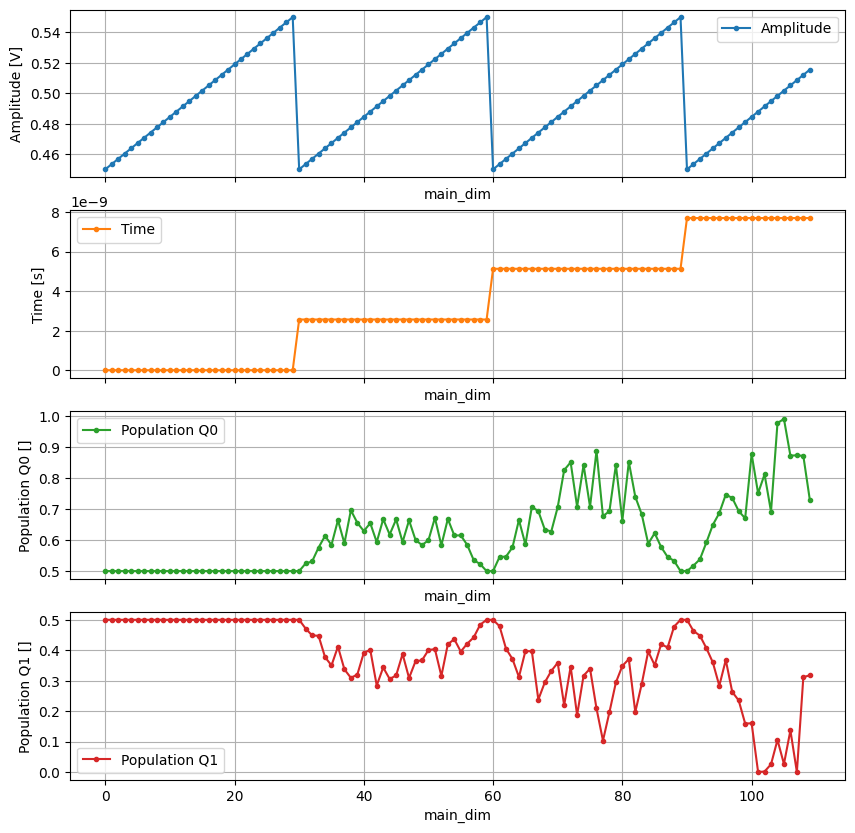

In [5]:
n_points = 110  # only plot a few points for clarity
_, axs = plt.subplots(4, 1, sharex=True, figsize=(10, 10))
dataset.amp[:n_points].plot(
    ax=axs[0], marker=".", color="C0", label=dataset.amp.long_name
)
dataset.time[:n_points].plot(
    ax=axs[1], marker=".", color="C1", label=dataset.time.long_name
)
_ = dataset.pop_q0.sel(repetitions=0)[:n_points].plot(
    ax=axs[2], marker=".", color="C2", label=dataset.pop_q0.long_name
)
_ = dataset.pop_q1.sel(repetitions=0)[:n_points].plot(
    ax=axs[3], marker=".", color="C3", label=dataset.pop_q1.long_name
)
for ax in axs:
    ax.legend()
    ax.grid()

As seen above, in the Quantify dataset the main coordinates do not explicitly index
the main variables because not all use-cases fit within this paradigm.
However, when possible, the Quantify dataset can be reshaped to take advantage of the
xarray built-in utilities.

<!-- FIXME when a Quantify dataset has a class re-evaluate the need for following sentence or some equivalent: -->
<!-- Note, however, that this reshaping will produce an xarray dataset that does not comply with the Quantify dataset specification. -->

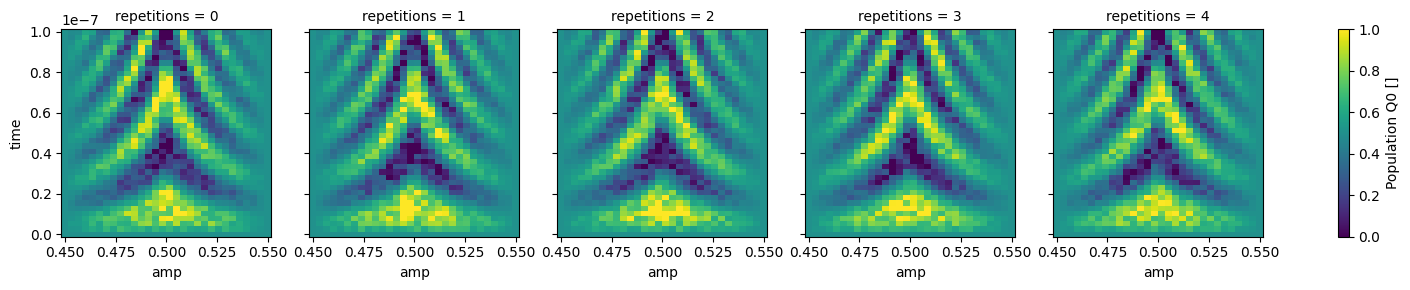

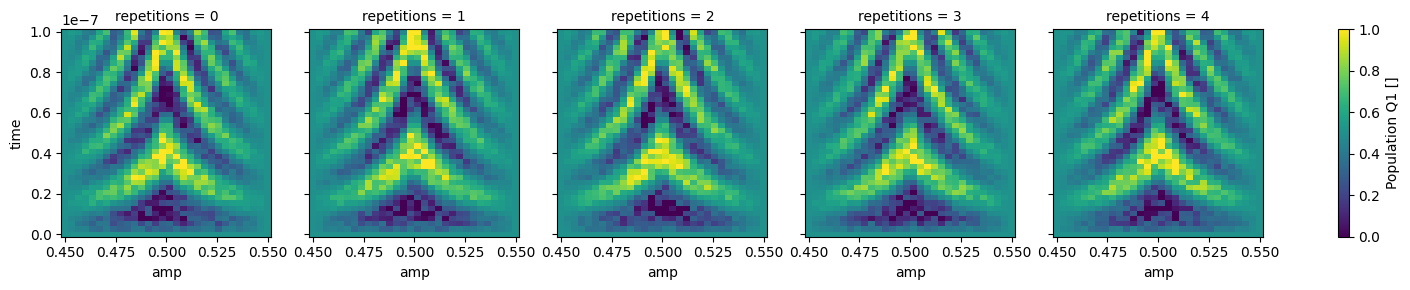

In [6]:
dataset_gridded = dh.to_gridded_dataset(
    dataset,
    dimension="main_dim",
    coords_names=dattrs.get_main_coords(dataset),
)
dataset_gridded.pop_q0.plot.pcolormesh(x="amp", col="repetitions")
_ = dataset_gridded.pop_q1.plot.pcolormesh(x="amp", col="repetitions")

## Dimensions

The main variables and coordinates present in a Quantify dataset have the following required and optional xarray dimensions:

### Main dimension(s) \[Required\]

The main dimensions comply with the following:

- The outermost dimension of any main coordinate/variable, OR the second outermost dimension if the outermost one is a {ref}`repetitions dimension <sec-repetitions-dimensions>`.
- Do not require to be explicitly specified in any metadata attributes, instead utilities for extracting them are provided. See {func}`~quantify_core.data.dataset_attrs.get_main_dims` which simply applies the rule above while inspecting all the main coordinates and variables present in the dataset.
- The dataset must have at least one main dimension.

```{admonition} Note on nesting main dimensions
Nesting main dimensions is allowed in principle and such examples are
provided but it should be considered an experimental feature.

- Intuition: intended primarily for time series, also known as "time trace" or simply trace. See {ref}`sec-dataset-t1-traces` for an example.
```

### Secondary dimension(s) \[Optional\]

Equivalent to the main dimensions but used by the secondary coordinates and variables.
The secondary dimensions comply with the following:

- The outermost dimension of any secondary coordinate/variable, OR the second outermost dimension if the outermost one is a {ref}`repetitions dimension <sec-repetitions-dimensions>`.
- Do not require to be explicitly specified in any metadata attributes, instead utilities for extracting them are provided. See {func}`~quantify_core.data.dataset_attrs.get_secondary_dims` which simply applies the rule above while inspecting all the secondary coordinates and variables present in the dataset.

(sec-repetitions-dimensions)=
### Repetitions dimension(s) \[Optional\]

Repetition dimensions comply with the following:

- Any dimension that is the outermost dimension of a main or secondary variable when its attribute {attr}`QVarAttrs.has_repetitions <quantify_core.data.dataset_attrs.QVarAttrs.has_repetitions>` is set to `True`.
- Intuition for this xarray dimension(s): the equivalent would be to have `dataset_reptition_0.hdf5`, `dataset_reptition_1.hdf5`, etc. where each dataset was obtained from repeating exactly the same experiment. Instead we define an outer dimension for this.
- Default behavior of (live) plotting and analysis tools can be to average the main variables along the repetitions dimension(s).
- Can be the outermost dimension of the main (and secondary) variables.
- Variables can lie along one (and only one) repetitions outermost dimension.

#### Example datasets with repetition

As shown in the {ref}`xarray-intro` an xarray dimension can be indexed by a `coordinate` variable. In this example the `repetitions` dimension is indexed by the `repetitions` xarray coordinate. Note that in an xarray dataset, a dimension and a data variable or a coordinate can share the same name. This might be confusing at first. It takes just a bit of dataset manipulation practice to gain an intuition for how it works.

In [7]:
coord_dims = ("repetitions",)
coord_values = ["A", "B", "C", "D", "E"]
dataset_indexed_rep = xr.Dataset(coords=dict(repetitions=(coord_dims, coord_values)))

dataset_indexed_rep

<xarray.Dataset> Size: 20B
Dimensions:      (repetitions: 5)
Coordinates:
  * repetitions  (repetitions) <U1 20B 'A' 'B' 'C' 'D' 'E'
Data variables:
    *empty*

In [8]:
# merge with the previous dataset
dataset_rep = dataset.merge(dataset_indexed_rep, combine_attrs="drop_conflicts")

assert dataset_rep == round_trip_dataset(dataset_rep)  # confirm read/write

dataset_rep

<xarray.Dataset> Size: 115kB
Dimensions:      (repetitions: 5, main_dim: 1200)
Coordinates:
    amp          (main_dim) float64 10kB 0.45 0.4534 0.4569 ... 0.5466 0.55
    time         (main_dim) float64 10kB 0.0 0.0 0.0 0.0 ... 1e-07 1e-07 1e-07
  * repetitions  (repetitions) <U1 20B 'A' 'B' 'C' 'D' 'E'
Dimensions without coordinates: main_dim
Data variables:
    pop_q0       (repetitions, main_dim) float64 48kB 0.5 0.5 0.5 ... 0.4818 0.5
    pop_q1       (repetitions, main_dim) float64 48kB 0.5 0.5 0.5 ... 0.5371 0.5
Attributes:
    tuid:                      20241014-175532-795-90ad16
    dataset_name:              
    dataset_state:             None
    timestamp_start:           None
    timestamp_end:             None
    quantify_dataset_version:  2.0.0
    software_versions:         {}
    relationships:             []
    json_serialize_exclude:    []

And as before, we can reshape the dataset to take advantage of the xarray built-in utilities.

In [9]:
dataset_gridded = dh.to_gridded_dataset(
    dataset_rep,
    dimension="main_dim",
    coords_names=dattrs.get_main_coords(dataset),
)
dataset_gridded

<xarray.Dataset> Size: 97kB
Dimensions:      (amp: 30, time: 40, repetitions: 5)
Coordinates:
  * amp          (amp) float64 240B 0.45 0.4534 0.4569 ... 0.5431 0.5466 0.55
  * time         (time) float64 320B 0.0 2.564e-09 5.128e-09 ... 9.744e-08 1e-07
  * repetitions  (repetitions) <U1 20B 'A' 'B' 'C' 'D' 'E'
Data variables:
    pop_q0       (repetitions, amp, time) float64 48kB 0.5 0.5 0.5 ... 0.5 0.5
    pop_q1       (repetitions, amp, time) float64 48kB 0.5 0.5 0.5 ... 0.5 0.5
Attributes:
    tuid:                      20241014-175532-795-90ad16
    dataset_name:              
    dataset_state:             None
    timestamp_start:           None
    timestamp_end:             None
    quantify_dataset_version:  2.0.0
    software_versions:         {}
    relationships:             []
    json_serialize_exclude:    []

It is now possible to retrieve (select) a specific entry along the `repetitions` dimension:

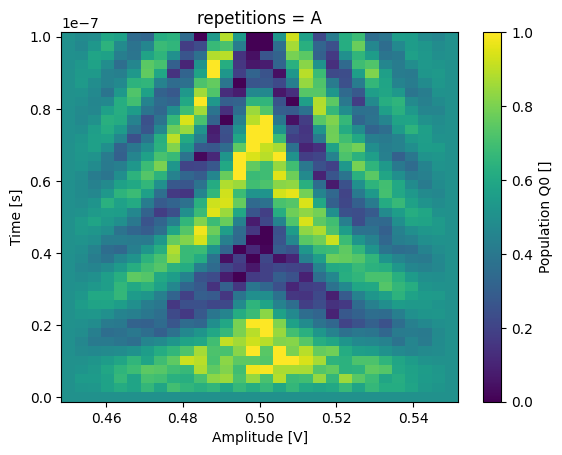

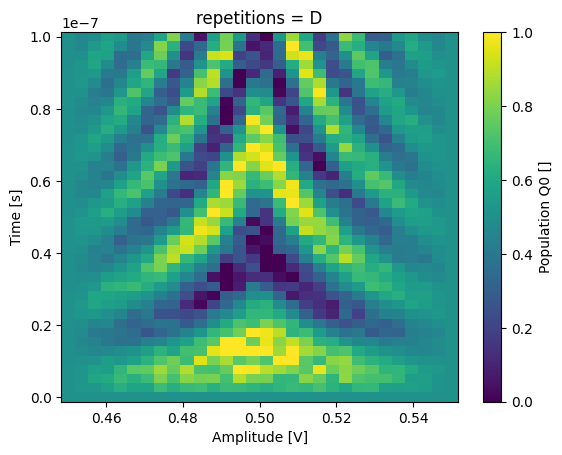

In [10]:
_ = dataset_gridded.pop_q0.sel(repetitions="A").plot(x="amp")
plt.show()
_ = dataset_gridded.pop_q0.sel(repetitions="D").plot(x="amp")

## Dataset attributes

The required attributes of the Quantify dataset are defined by the following dataclass.
It can be used to generate a default dictionary that is attached to a dataset under the {attr}`xarray.Dataset.attrs` attribute.

```{eval-rst}
.. autoclass:: quantify_core.data.dataset_attrs.QDatasetAttrs
    :members:
    :noindex:
    :show-inheritance:
```

Additionally in order to express relationships between coordinates and/or variables
the following template is provided:

```{eval-rst}
.. autoclass:: quantify_core.data.dataset_attrs.QDatasetIntraRelationship
    :members:
    :noindex:
    :show-inheritance:
```

In [11]:
from quantify_core.data.dataset_attrs import QDatasetAttrs

# tip: to_json and from_dict, from_json  are also available
dataset.attrs = QDatasetAttrs().to_dict()
dataset.attrs


{
    'tuid': None,
    'dataset_name': '',
    'dataset_state': None,
    'timestamp_start': None,
    'timestamp_end': None,
    'quantify_dataset_version': '2.0.0',
    'software_versions': {},
    'relationships': [],
    'json_serialize_exclude': []
}

Note that xarray automatically provides the entries of the dataset attributes as python attributes. And similarly for the xarray coordinates and data variables.

In [12]:
dataset.quantify_dataset_version, dataset.tuid

('2.0.0', None)

## Main coordinates and variables attributes

Similar to the dataset attributes ({attr}`xarray.Dataset.attrs`), the main coordinates and variables have each their own required attributes attached to them as a dictionary under the {attr}`xarray.DataArray.attrs` attribute.

```{eval-rst}
.. autoclass:: quantify_core.data.dataset_attrs.QCoordAttrs
    :members:
    :noindex:
    :show-inheritance:
```

In [13]:
dataset.amp.attrs


{
    'unit': 'V',
    'long_name': 'Amplitude',
    'is_main_coord': True,
    'uniformly_spaced': True,
    'is_dataset_ref': False,
    'json_serialize_exclude': []
}

```{eval-rst}
.. autoclass:: quantify_core.data.dataset_attrs.QVarAttrs
    :members:
    :noindex:
    :show-inheritance:
```

In [14]:
dataset.pop_q0.attrs


{
    'unit': '',
    'long_name': 'Population Q0',
    'is_main_var': True,
    'uniformly_spaced': True,
    'grid': True,
    'is_dataset_ref': False,
    'has_repetitions': True,
    'json_serialize_exclude': []
}

## Storage format

The Quantify dataset is written to disk and loaded back making use of xarray-supported facilities.
Internally we write and load to/from disk using:

In [15]:
display_source_code(dh.write_dataset)
display_source_code(dh.load_dataset)

def write_dataset(path: Path | str, dataset: xr.Dataset) -> None:
    """Writes a :class:`~xarray.Dataset` to a file with the `h5netcdf` engine.

    Before writing the
    :meth:`~quantify_core.data.dataset_adapters.AdapterH5NetCDF.adapt`
    is applied.

    To accommodate for complex-type numbers and arrays ``invalid_netcdf=True`` is used.

    Parameters
    ----------
    path
        Path to the file including filename and extension
    dataset
        The :class:`~xarray.Dataset` to be written to file.
    """  # pylint: disable=line-too-long
    _xarray_numpy_bool_patch(dataset)  # See issue #161 in quantify-core
    # Only quantify_dataset_version=>2.0.0 requires the adapter
    if "quantify_dataset_version" in dataset.attrs:
        dataset = da.AdapterH5NetCDF.adapt(dataset)
    dataset.to_netcdf(path, engine="h5netcdf", invalid_netcdf=True)

def load_dataset(
    tuid: TUID,
    datadir: Path | str | None = None,
    name: str = DATASET_NAME,
) -> xr.Dataset:
    """Loads a dataset specified by a tuid.

    .. tip::

        This method also works when specifying only the first part of a
        :class:`~quantify_core.data.types.TUID`.

    .. note::

        This method uses :func:`~.load_dataset` to ensure the file is closed after
        loading as datasets are intended to be immutable after performing the initial
        experiment.

    Parameters
    ----------
    tuid
        A :class:`~quantify_core.data.types.TUID` string. It is also possible to specify
        only the first part of a tuid.
    datadir
        Path of the data directory. If ``None``, uses :meth:`~get_datadir` to determine
        the data directory.
    name
        Name of the dataset.

    Returns
    -------
    :
        The dataset.

    Raises
    ------
    FileNotFoundError
        No data found for specified date.
    """
    return load_dataset_from_path(_locate_experiment_file(tuid, datadir, name))

Note that we use the `h5netcdf` engine which is more permissive than the default NetCDF engine to accommodate arrays of complex numbers.

```{note}
Furthermore, in order to support a variety of attribute types (e.g. the `None` type) and shapes (e.g. nested dictionaries) in a seamless dataset round trip, some additional tooling is required. See source codes below that implements the two-way conversion adapter used by the functions shown above.
```

In [16]:
display_source_code(dadapters.AdapterH5NetCDF)

class AdapterH5NetCDF(DatasetAdapterBase):
    """
    Quantify dataset adapter for the ``h5netcdf`` engine.

    It has the functionality of adapting the Quantify dataset to a format compatible
    with the ``h5netcdf`` xarray backend engine that is used to write and load the
    dataset to/from disk.

    .. warning::

        The ``h5netcdf`` engine has minor issues when performing a two-way trip of the
        dataset. The ``type`` of some attributes are not preserved. E.g., list- and
        tuple-like objects are loaded as numpy arrays of ``dtype=object``.
    """

    @classmethod
    def adapt(cls, dataset: xr.Dataset) -> xr.Dataset:
        """
        Serializes to JSON the dataset and variables attributes.

        To prevent the JSON serialization for specific items, their names should be
        listed under the attribute named ``json_serialize_exclude`` (for each ``attrs``
        dictionary).

        Parameters
        ----------
        dataset
            Dataset that needs to be adapted.

        Returns
        -------
        :
            Dataset in which the attributes have been replaced with their JSON strings
            version.
        """

        return cls._transform(dataset, vals_converter=json.dumps)

    @classmethod
    def recover(cls, dataset: xr.Dataset) -> xr.Dataset:
        """
        Reverts the action of ``.adapt()``.

        To prevent the JSON de-serialization for specific items, their names should be
        listed under the attribute named ``json_serialize_exclude``
        (for each ``attrs`` dictionary).

        Parameters
        ----------
        dataset
            Dataset from which to recover the original format.

        Returns
        -------
        :
            Dataset in which the attributes have been replaced with their python objects
            version.
        """

        return cls._transform(dataset, vals_converter=json.loads)

    @staticmethod
    def attrs_convert(
        attrs: dict,
        inplace: bool = False,
        vals_converter: Callable[Any, Any] = json.dumps,
    ) -> dict:
        """
        Converts to/from JSON string the values of the keys which are not listed in the
        ``json_serialize_exclude`` list.

        Parameters
        ----------
        attrs
            The input dictionary.
        inplace
            If ``True`` the values are replaced in place, otherwise a deepcopy of
            ``attrs`` is performed first.
        """
        json_serialize_exclude = attrs.get("json_serialize_exclude", [])

        attrs = attrs if inplace else deepcopy(attrs)
        for attr_name, attr_val in attrs.items():
            if attr_name not in json_serialize_exclude:
                attrs[attr_name] = vals_converter(attr_val)
        return attrs

    @classmethod
    def _transform(
        cls, dataset: xr.Dataset, vals_converter: Callable[Any, Any] = json.dumps
    ) -> xr.Dataset:
        dataset = xr.Dataset(
            dataset,
            attrs=cls.attrs_convert(
                dataset.attrs, inplace=False, vals_converter=vals_converter
            ),
        )

        for var_name in dataset.variables.keys():
            # The new dataset generated above has already a deepcopy of the attributes.
            _ = cls.attrs_convert(
                dataset[var_name].attrs, inplace=True, vals_converter=vals_converter
            )

        return dataset